In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from pathlib import Path

In [2]:
data_dir = Path("../../data/processed")
X_train = pd.read_parquet(data_dir / "X_train.parquet")
X_val = pd.read_parquet(data_dir / "X_val.parquet")
y_train = pd.read_parquet(data_dir / "y_train.parquet").squeeze()
y_val = pd.read_parquet(data_dir / "y_val.parquet").squeeze()
X_test = pd.read_parquet(data_dir / "X_test.parquet")
test_ids = pd.read_parquet(data_dir / "test_ids.parquet")['id']

In [ ]:
# не запускать это
#critical_events = X_train[y_train > 0.6].copy()
#critical_events = critical_events.sort_values(by='sum_risk', ascending=False)

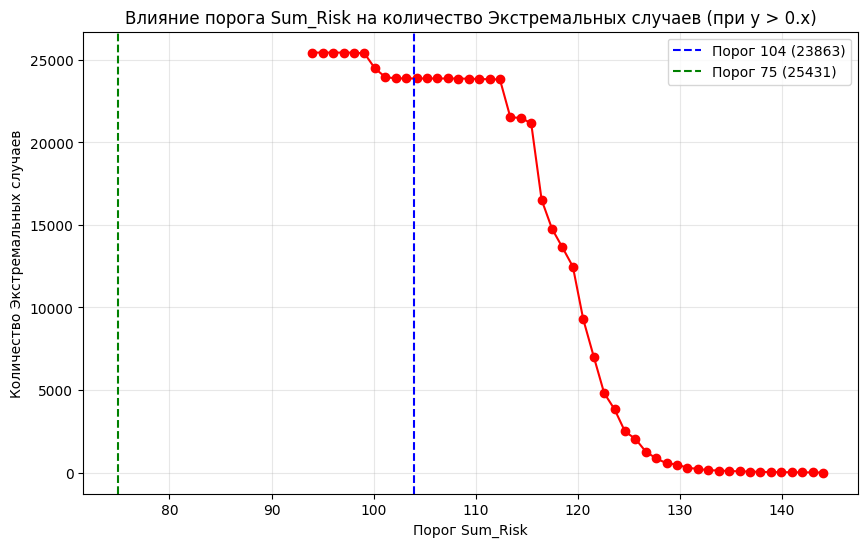

In [ ]:
# не запускать, тест
#import matplotlib.pyplot as plt
#import numpy as np

thresholds = np.linspace(
    critical_events['sum_risk'].min(), 
    critical_events['sum_risk'].max(), 
    num=50
)

counts = []
for t in thresholds:
    count = (critical_events['sum_risk'] > t).sum()
    counts.append(count)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, counts, marker='o', linestyle='-', color='red')
plt.axvline(x=104, color='blue', linestyle='--', label=f'Порог 104 ({counts[np.argmin(np.abs(thresholds - 104))]})')
plt.axvline(x=75, color='green', linestyle='--', label=f'Порог 75 ({counts[np.argmin(np.abs(thresholds - 75))]})')

plt.title('Влияние порога Sum_Risk на количество Экстремальных случаев (при y > 0.х)')
plt.xlabel('Порог Sum_Risk')
plt.ylabel('Количество Экстремальных случаев')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
y_class_train = ((y_train > 0.54) & (X_train['sum_risk'] > 104)).astype(int)
print(f"Экстремальных случаев в train: {y_class_train.sum()}")

Экстремальных случаев в train: 177555


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test) # Не забываем про тест!

In [5]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_class_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [6]:
train_meta = log_reg.predict_proba(X_train_scaled)[:, 1]
val_meta = log_reg.predict_proba(X_val_scaled)[:, 1]
test_meta = log_reg.predict_proba(X_test_scaled)[:, 1]

In [7]:
X_train['extreme_risk_feature'] = train_meta
X_val['extreme_risk_feature'] = val_meta
X_test['extreme_risk_feature'] = test_meta

In [8]:
print("Первые 5 строк X_train с новым признаком:")
print(X_train.head())

Первые 5 строк X_train с новым признаком:
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 5                   5                7              4   
1                 5                   6                6              5   
2                 7                   6                3              8   
3                 6                   8                2              6   
4                 4                   5                2              4   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             3              8            3          1                      3   
1             4              8            7          9                      2   
2             7              7            2          1                      2   
3             4              4            3          7                      5   
4             4              6           10          6                      8   

   Encroachments  ..

In [9]:
print("\nСтатистика нового признака:")
print(X_train['extreme_risk_feature'].describe())
print("Статистика нового признака extreme_risk_feature:")
print(X_train['extreme_risk_feature'].describe())


Статистика нового признака:
count    8.943650e+05
mean     1.985451e-01
std      3.618999e-01
min      4.115877e-23
25%      3.354979e-07
50%      8.891572e-05
75%      1.346576e-01
max      1.000000e+00
Name: extreme_risk_feature, dtype: float64
Статистика нового признака extreme_risk_feature:
count    8.943650e+05
mean     1.985451e-01
std      3.618999e-01
min      4.115877e-23
25%      3.354979e-07
50%      8.891572e-05
75%      1.346576e-01
max      1.000000e+00
Name: extreme_risk_feature, dtype: float64


In [8]:
final_model = LinearRegression()
final_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
y_val_pred = final_model.predict(X_val)
print(f"R2 Score (Stacking): {r2_score(y_val, y_val_pred):.5f}")

R2 Score (Stacking): 0.84553


In [10]:
y_test_pred = final_model.predict(X_test)

In [11]:
submission = pd.DataFrame({'id': test_ids, 'FloodProbability': y_test_pred})
submission.to_csv(data_dir / "submission_stacking.csv", index=False)
print("Saved submission_stacking.csv")

Saved submission_stacking.csv
